In [9]:
# from kaggle.api.kaggle_api_extended import KaggleApi
# import os

# # Authenticate Kaggle API
# api = KaggleApi()
# api.authenticate()

# # Correct dataset name
# dataset_name = 'masoudnickparvar/brain-tumor-mri-dataset'  # Replace with actual dataset name

# # Define the download path (use raw string for Windows path)
# download_path = r"D:\Deep_Learning\Brain_Tumor_type_detection"

# # Create the folder if it doesn’t exist
# os.makedirs(download_path, exist_ok=True)

# # Download and unzip the dataset
# api.dataset_download_files(dataset_name, path=download_path, unzip=True)

# print(f"Dataset downloaded successfully to: {download_path}")

In [4]:
import tensorflow as tf
print(tf.__file__)

c:\Users\chint\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\__init__.py


In [5]:
import tensorflow as tf
import numpy as np

# Paths to your dataset
train_path = 'D:/Deep_Learning/Brain_Tumor_type_detection/training'
test_path = 'D:/Deep_Learning/Brain_Tumor_type_detection/testing'

# Image size and batch size
img_size = (224, 224)
batch_size = 32

# Load training and testing datasets with a validation split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.15,  # 15% of data will be used for validation
    subset="training",
    seed=42,
    shuffle=True  # Shuffle to ensure proper split
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.15,
    subset="validation",
    seed=42,
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False  # No need to shuffle test data
)


Found 5712 files belonging to 4 classes.
Using 4856 files for training.
Found 5712 files belonging to 4 classes.
Using 856 files for validation.
Found 1311 files belonging to 4 classes.


In [6]:

# Class names for reference
class_names = train_ds.class_names
print("Class names:", class_names)  # E.g., ['glioma', 'meningioma', 'pituitary', 'no_tumor']

# One-hot encoding function using TensorFlow operations
def one_hot_labels(ds, num_classes=4):
    def encode_fn(image, label):
        label = tf.one_hot(label, num_classes)
        return image, label

    return ds.map(encode_fn)

# Convert labels to one-hot encoding
train_ds = one_hot_labels(train_ds)
val_ds = one_hot_labels(val_ds)
test_ds = one_hot_labels(test_ds)

# Optimize dataset performance (caching and prefetching)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [7]:

# Build CNN model
model = tf.keras.Sequential([
    # Convolutional base
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),  # After Flatten, as preferred
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 classes (glioma, meningioma, pituitary, no_tumor)
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Since we are using one-hot encoding
    metrics=['accuracy']
)

# Model summary
model.summary()

# Train model
history = model.fit(
    train_ds,
    epochs=10,  # Adjust epochs as necessary
    validation_data=val_ds
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

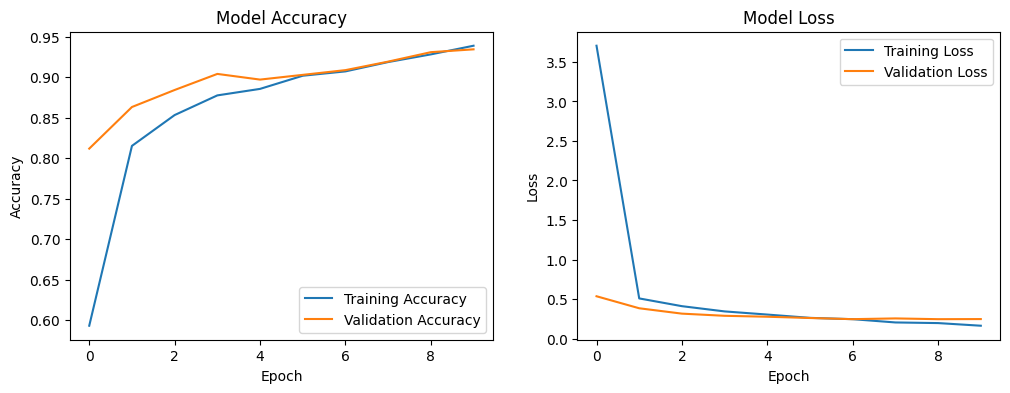

In [14]:
from matplotlib import pyplot as plt
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [15]:
# Test one image
for images, labels in test_ds.take(1):  # Take first batch
    single_image = images[0:1]  # (1, 224, 224, 3)
    true_label = labels[0]      # (4,)
    break

pred = model.predict(single_image)
predicted_class = np.argmax(pred[0])
true_class = np.argmax(true_label)
print(f"Predicted Class: {class_names[predicted_class]}, True Class: {class_names[true_class]}")
print(f"Probabilities: {pred[0]}")

# Save model
model.save('brain_tumor_4class_model.h5')

1/1 [==============================] - 0s 152ms/step
Predicted Class: glioma, True Class: glioma
Probabilities: [9.9996257e-01 2.0266261e-05 5.4961288e-06 1.1730811e-05]


c:\Users\chint\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 5712 files belonging to 4 classes.
Using 4856 files for training.
Found 5712 files belonging to 4 classes.
Using 856 files for validation.
Found 1311 files belonging to 4 classes.
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               77070848  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
    

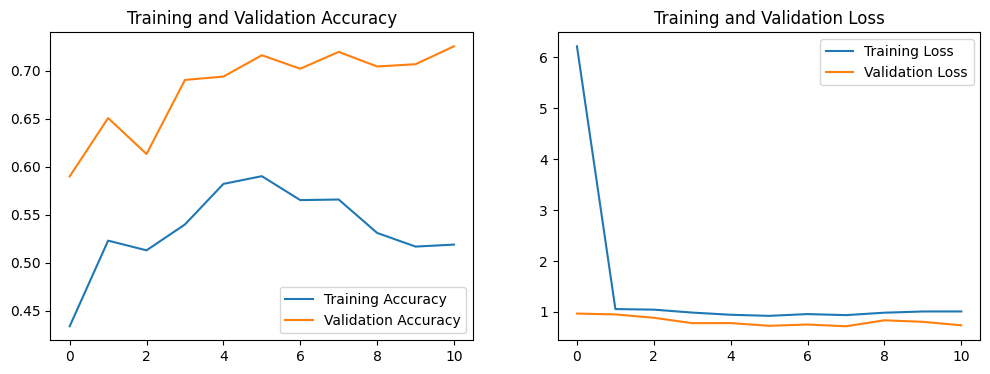

In [16]:
import tensorflow as tf
import numpy as np

# Paths to your dataset
train_path = 'D:/Deep_Learning/Brain_Tumor_type_detection/training'
test_path = 'D:/Deep_Learning/Brain_Tumor_type_detection/testing'

# Image size and batch size
img_size = (224, 224)
batch_size = 32

# Load training and testing datasets with a validation split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.15,  # 15% of data will be used for validation
    subset="training",
    seed=42,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.15,
    subset="validation",
    seed=42,
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# Class names for reference
class_names = train_ds.class_names
print("Class names:", class_names)  # E.g., ['glioma', 'meningioma', 'pituitary', 'no_tumor']

# One-hot encoding function using TensorFlow operations
def one_hot_labels(ds, num_classes=4):
    def encode_fn(image, label):
        label = tf.one_hot(label, num_classes)
        return image, label
    return ds.map(encode_fn)

# Convert labels to one-hot encoding
train_ds = one_hot_labels(train_ds)
val_ds = one_hot_labels(val_ds)
test_ds = one_hot_labels(test_ds)

# Optimize dataset performance (caching and prefetching)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Build ANN model
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),  # Normalize pixel values to [0, 1]
    tf.keras.layers.Flatten(),  # Flatten the 224x224x3 input to a 1D vector
    tf.keras.layers.Dense(512, activation='relu'),  # First dense layer
    tf.keras.layers.Dropout(0.5),  # Dropout to prevent overfitting
    tf.keras.layers.Dense(128, activation='relu'),  # Second dense layer
    tf.keras.layers.Dense(4, activation='softmax')  # Output layer for 4 classes
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # For one-hot encoded labels
    metrics=['accuracy']
)

# Model summary
model.summary()

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train model
history = model.fit(
    train_ds,
    epochs=50,  # Higher epochs, early stopping will halt if needed
    validation_data=val_ds,
    callbacks=[early_stopping]
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Optional: Plot training and validation metrics
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [18]:
import tensorflow as tf
import numpy as np

# Paths to your dataset
train_path = 'D:/Deep_Learning/Brain_Tumor_type_detection/training'
test_path = 'D:/Deep_Learning/Brain_Tumor_type_detection/testing'

# Image size and batch size
img_size = (224, 224)  # VGG16 expects 224x224 input
batch_size = 32

# Load training and testing datasets with a validation split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.15,
    subset="training",
    seed=42,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.15,
    subset="validation",
    seed=42,
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# Class names for reference
class_names = train_ds.class_names
print("Class names:", class_names)

# One-hot encoding function
def one_hot_labels(ds, num_classes=4):
    def encode_fn(image, label):
        label = tf.one_hot(label, num_classes)
        return image, label
    return ds.map(encode_fn)

# Convert labels to one-hot encoding
train_ds = one_hot_labels(train_ds)
val_ds = one_hot_labels(val_ds)
test_ds = one_hot_labels(test_ds)

# Optimize dataset performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Load VGG16 as the convolutional base (pre-trained on ImageNet)
base_model = tf.keras.applications.VGG16(
    include_top=False,  # Exclude the top dense layers
    weights='imagenet',  # Use pre-trained weights
    input_shape=(224, 224, 3)
)

# Freeze the base model to prevent its weights from being updated during initial training
base_model.trainable = False

# Build the model with VGG16 base
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Lambda(lambda x: tf.keras.applications.vgg16.preprocess_input(x)),  # VGG-specific preprocessing
    base_model,  # VGG16 convolutional base
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 classes
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Train model (initial training with frozen base)
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
)

# Optional: Fine-tune by unfreezing some VGG layers
base_model.trainable = True
# Freeze all layers except the last few (e.g., last 4 layers for fine-tuning)
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Recompile with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_fine = model.fit(
    train_ds,
    epochs=10,  # Additional epochs for fine-tuning
    validation_data=val_ds
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")

Found 5712 files belonging to 4 classes.
Using 4856 files for training.
Found 5712 files belonging to 4 classes.
Using 856 files for validation.
Found 1311 files belonging to 4 classes.
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 512)               12845568  
    

KeyboardInterrupt: 